In [1]:
import pandas as pd
import numpy as np
import warnings

from scipy import stats
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from joblib import Parallel, delayed

import datetime
from glob import glob

<AxesSubplot:xlabel='time'>

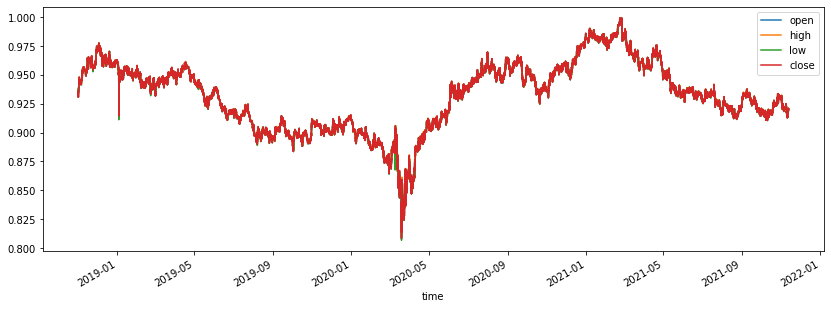

In [2]:
data_path = glob('zip_data/*.csv')[0]
data = pd.read_csv(data_path, index_col=0)
data.index = pd.to_datetime(data.index)
data.plot(figsize=(14,5))

In [3]:
data_path

'zip_data/AUDCAD.csv'

In [4]:
global PositionMoney
PositionMoney = 100_000

def selection_logic(index_data: datetime.date):
    """
    Определяется поведение разбиения данных на период Lookback и Hold
    :param index_data: Подразумевается что сюда приходит день в который планируется работа стратегии
    :return:
    """
    ASIAN_START = datetime.datetime.combine(index_data, datetime.time(hour=22)) #   Начало азиатской сессии
    ASIAN_END = datetime.datetime.combine(index_data + datetime.timedelta(days=1), datetime.time(hour=8))   #   Конец азиатской сессии == Начало английской
    ENGLISH_END = datetime.datetime.combine(index_data + datetime.timedelta(days=1), datetime.time(hour=22))    #   Конец английской сессии
    return ASIAN_END, ASIAN_START, ENGLISH_END


def FX_opening_trade(sampling_data, UpperBorder, LowerBorder, POSITION_MONEY_VOLUME=10):
    """
    Функция проверяет есть ли точки входа на POTENTIAL_HOLD_DATA периоде
    :param sampling_data:
    :param UpperBorder:
    :param LowerBorder:
    :return:

    >>>sampl = pd.Series([.1,0,1,2,4,1,0])
    >>>FX_opening_trade(sampl, 6, .05) # {'logic': None, 'type': None, 'position': None, 'open_time': None}

    >>>sampl = pd.Series([1,2,3,4,5,6,7])
    >>>FX_opening_trade(sampl, 6, .05) # {'logic': True, 'type': 'BUY', 'position': 14285.714285714286, 'open_time': 6}
    """

    #POSITION_MONEY_VOLUME = 10 #   Параметр отвечающий за размер каждой сделки

    answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}    #   Унифицированный объем шаблона
    for index in sampling_data.index:
        #   Opening Long Order Logic
        if sampling_data.loc[index] > UpperBorder:
            answer_template['logic'] = True
            answer_template['type'] = "BUY"
            answer_template['position'] = abs(POSITION_MONEY_VOLUME / sampling_data.loc[index])
            answer_template['open_time'] = index
            answer_template['open_price'] = sampling_data.loc[index]
            if sampling_data.loc[index] == 0:
                warnings.warn("Zero Division in case zero price in sample. Sample ignored")
                answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}
            break

        #   Opening Short Order Logic
        if sampling_data.loc[index] < LowerBorder:
            answer_template['logic'] = True
            answer_template['type'] = "SELL"
            answer_template['position'] = abs(POSITION_MONEY_VOLUME / sampling_data.loc[index])
            answer_template['open_time'] = index
            answer_template['open_price'] = sampling_data.loc[index]
            if sampling_data.loc[index] == 0:
                warnings.warn("Zero Division in case zero price in sample. Sample ignored")
                answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}
            break
    return answer_template

def FX_hold_logic(holding_data, open_list, SLIPADGE, PROFITS_LIST):
    HoldList = {"hold_logic": "END_PERIOD", "close_time": holding_data.index[-1], "close_price": holding_data.loc[holding_data.index[-1]]}
    # Фактически тут прописывается логика будет ли досрочное закрытие позиции
    operation_type = open_list['type']
    position = open_list['position']
    start_price = open_list['open_price']
    SlipadgePPos = SLIPADGE / (start_price * position)

    BUY_TP = PROFITS_LIST["BUY"]["profit"]
    BUY_SL = PROFITS_LIST["BUY"]["loss"]

    SELL_TP = PROFITS_LIST["SELL"]["profit"]
    SELL_SL = PROFITS_LIST["SELL"]["loss"]
    #   Если за время периода владения активом/обязательством произойдут события описанные ниже - досрочно выходим из сделки
    for index in holding_data.index:
        if operation_type == "BUY":
            if (holding_data.loc[index] / start_price) - 1 > BUY_TP + SlipadgePPos:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

            if (holding_data.loc[index] / start_price) - 1 < -1 * (BUY_SL + SlipadgePPos):
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

        if operation_type == "SELL":
            if (start_price / holding_data.loc[index]) - 1 > SELL_TP + SlipadgePPos:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            if (start_price / holding_data.loc[index]) - 1 < -1 * (SELL_SL + SlipadgePPos):
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

    return HoldList



def CalculateReturn(OrderList, HoldList, SLIPADGE, POSITION_MONEY_VOLUME):
    """
    Тут прописывается логика расчета
    :param OrderList:
    :param HoldList:
    :param SLIPADGE:
    :return:
    """
    if OrderList["type"] == "BUY":
        ret = OrderList["position"] * (HoldList["close_price"] - OrderList["open_price"]) - SLIPADGE
        own_time = HoldList["close_time"] - OrderList["open_time"]

    elif OrderList["type"] == "SELL":
        ret = POSITION_MONEY_VOLUME - OrderList["position"] * HoldList["close_price"] - SLIPADGE
        own_time = HoldList["close_time"] - OrderList["open_time"]
    else:
        warnings.warn("Something goes wrong while calculation of return")
        ret = None
        own_time = None
    return {"Operation Return": ret, "Operation Owning Time": own_time}


def buying_trigger(sampling_data: pd.Series, median_dot: datetime.datetime, PROFITS_LIST, SLIPADGE=10, POSITION_MONEY_VOLUME=100):
    """
    Выполняет роль центрального узла связывающего все элементы выполнения стратегии. Планируется что передаются данные полученные из функции предобработки
    FIXME Нужно учитывать что открыть дробную позицию нельзя. Поэтому нужно оставлять параметр FREE CASH
    :param sampling_data:
    :param median_dot:
    :param SLIPADGE:
    :return:
    """
    #   sampling_data = pd.Series([10,10,10,8,6,20,10,9])
    #   media_dot= 2
    UpperBorder = sampling_data.loc[:median_dot].max()  #   Определение верхней границы
    LowerBorder = sampling_data.loc[:median_dot].min()  #   Определение нижней границы
    HoldPeriod = sampling_data.loc[median_dot:] #   Период в течении которого будем пытаться делать ордер

    GetOrderFilter = FX_opening_trade(HoldPeriod, UpperBorder=UpperBorder, LowerBorder=LowerBorder, POSITION_MONEY_VOLUME=POSITION_MONEY_VOLUME)
    #   print(GetOrderFilter)   {'logic': True, 'type': 'SELL', 'position': 12.5, 'open_time': 3, 'open_price': 8}
    if not GetOrderFilter['logic']:
        return None

    #   Если нашлась точка входа то продолжаем выполнение
    if GetOrderFilter['logic']:
        operation_type = GetOrderFilter['type']
        position = GetOrderFilter['position']
        open_time = GetOrderFilter['open_time']
        holding_period_data = sampling_data.loc[open_time:] #   Период на котором выполняются условия владения активов/обязательством

        """        HoldingResultList = FX_hold_logic(holding_data=holding_period_data, open_list=GetOrderFilter,
                                          SLIPADGE=SLIPADGE,
                                          PROFITS_LIST={
                                          "BUY":{
                                              "profit":.01,
                                              "loss":.01,
                                          },
                                          "SELL":{
                                              "profit":.01,
                                              "loss":.01,
                                          }
                                          })"""
        HoldingResultList = FX_hold_logic(holding_data=holding_period_data, open_list=GetOrderFilter,
                                          SLIPADGE=SLIPADGE, PROFITS_LIST=PROFITS_LIST)
        #   print(HoldingResultList)    {'hold_logic': 'TAKE_PROFIT', 'close_time': 4, 'close_price': 6}
        HoldProfit = CalculateReturn(GetOrderFilter, HoldList=HoldingResultList,
                                     POSITION_MONEY_VOLUME=POSITION_MONEY_VOLUME,SLIPADGE=SLIPADGE)
        #   print(HoldProfit)   {'Operation Return': 15.0, 'Operation Owning Time': 1}
        TotalList = {'logic': GetOrderFilter['logic'],
                     'operation_type': GetOrderFilter['type'],
                     'operation_position': GetOrderFilter['position'],
                     'position_open_time': GetOrderFilter['open_time'],
                     'open_price': GetOrderFilter['open_price'],
                     'holding_logic': HoldingResultList['hold_logic'],
                     'position_close_time': HoldingResultList['close_time'],
                     'position_close_price': HoldingResultList['close_price'],
                     'operation_money_return': HoldProfit['Operation Return'],
                     'position_holding_time': HoldProfit['Operation Owning Time']}
        #print(TotalList)
        #   print(TotalList)   {'logic': True, 'operation_type': 'SELL', 'operation_position': 12.5, 'position_open_time': 3, 'open_price': 8, 'holding_logic': 'TAKE_PROFIT', 'position_close_time': 4, 'position_close_price': 6, 'operation_money_return': 15.0, 'position_holding_time': 1}
        return TotalList

#sampl = pd.Series([10,10,10,8,6,20,10,9])
#print(sampl)
#buying_trigger(sampl, 2)

#   По идее этот метод работает корректно. Единственное что меня смущает - это то что нужно "занулять" отрицательный pnl
def SharpeModuleOld(MONEY_ARRAY_IN, DATES_ARRAY, BEAUTIFUL_PNL=True):
    MONEY_ARRAY = [x if x > 0 else 0 for x in MONEY_ARRAY_IN]
    if len(DATES_ARRAY) > 2:
        MONEY_DF = pd.DataFrame(columns=['date', 'pnl'])

        for e, _ in enumerate(pd.date_range(min(DATES_ARRAY), max(DATES_ARRAY))):
            if _.date() in DATES_ARRAY:
                MONEY_DF = MONEY_DF.append([{'date': _.date(), 'pnl': MONEY_ARRAY[DATES_ARRAY.index(_)]}])
            if _.date() not in DATES_ARRAY:
                MONEY_DF = MONEY_DF.append([{'date': _.date(), 'pnl': MONEY_DF.iloc[-1].pnl}])

        if BEAUTIFUL_PNL:
            plt.figure(figsize=(18, 10))
            plt.xticks(rotation=90)
            plt.grid(alpha=.1)
            plt.plot(MONEY_DF.set_index('date'))
            plt.show()

        MNY_RET = MONEY_DF.pnl.pct_change()[1:].replace([np.inf, -np.inf, np.nan], 0).values
        MNY_RET = np.subtract(np.array(MNY_RET), 0.05/252)
        SHARPE = np.mean(MNY_RET)/ np.std(MNY_RET)
        print('SHARPE:', round(np.sqrt(len(MNY_RET)) * SHARPE, 3))
        return round(np.sqrt(len(MNY_RET)) * SHARPE, 3)
    else:
        return None

def SharpeModuleNew(MONEY_ARRAY_IN, DATES_ARRAY, BEAUTIFUL_PNL=True):
    MONEY_ARRAY = [x for x in MONEY_ARRAY_IN]

    if len(DATES_ARRAY) > 2:
        MONEY_DF = pd.DataFrame(columns=['date', 'pnl'])

        for e, _ in enumerate(pd.date_range(min(DATES_ARRAY), max(DATES_ARRAY))):
            if _.date() in DATES_ARRAY:
                MONEY_DF = MONEY_DF.append([{'date': _.date(), 'pnl': MONEY_ARRAY[DATES_ARRAY.index(_)]}])
            if _.date() not in DATES_ARRAY:
                MONEY_DF = MONEY_DF.append([{'date': _.date(), 'pnl': MONEY_DF.iloc[-1].pnl}])

        if BEAUTIFUL_PNL:
            plt.figure(figsize=(18, 10))
            plt.xticks(rotation=90)
            plt.grid(alpha=.1)
            plt.plot(MONEY_DF.set_index('date'))
            plt.show()

        PNL = MONEY_DF.pnl.values
        NORMAL_MNY = [(PNL[index] - PNL[index - 1]) / abs(PNL[index - 1]) for index in range(1, len(PNL))]
        MNY_RET = NORMAL_MNY
        #MNY_RET = MONEY_DF.pnl.pct_change()[1:].replace([np.inf, -np.inf, np.nan], 0).values
        MNY_RET = np.subtract(np.array(MNY_RET), 0.05/252)
        SHARPE = np.mean(MNY_RET)/ np.std(MNY_RET)
        print('SHARPE:', round(np.sqrt(len(MNY_RET)) * SHARPE, 3))
        return round(np.sqrt(len(MNY_RET)) * SHARPE, 3)
    else:
        return None

def SharpeReturns(strategy_result):
    trade_days = list(strategy_result.position_close_time.dt.date.values)
    operation_returns = list(strategy_result.operation_money_return / PositionMoney)
    if len(trade_days) > 2:
        MONEY_DF = pd.DataFrame(columns=['date', 'money_change'])
        for e, _ in enumerate(pd.date_range(min(trade_days), max(trade_days))):
            if _.date() in trade_days:
                MONEY_DF = MONEY_DF.append([{'date': _.date(), 'money_change': operation_returns[trade_days.index(_)]}])
            if _.date() not in trade_days:
                MONEY_DF = MONEY_DF.append([{'date': _.date(), 'money_change': 0}])

    #print(MONEY_DF.reset_index(drop=True))
    MNY_RET = np.subtract(np.array(MONEY_DF.money_change), 0)
    SHARPE = round(np.sqrt(252) * MNY_RET.mean() / MONEY_DF.money_change.std(), 3)
    return SHARPE

In [22]:

FX_data = pd.read_csv('zip_data/AUDCAD.csv', index_col=0)
FX_data.index = pd.to_datetime(FX_data.index)
FX_data = FX_data.resample('1H').first()
FX_data = FX_data

  0%|          | 0/1109 [00:00<?, ?it/s]

Sharpe = -1.254
766


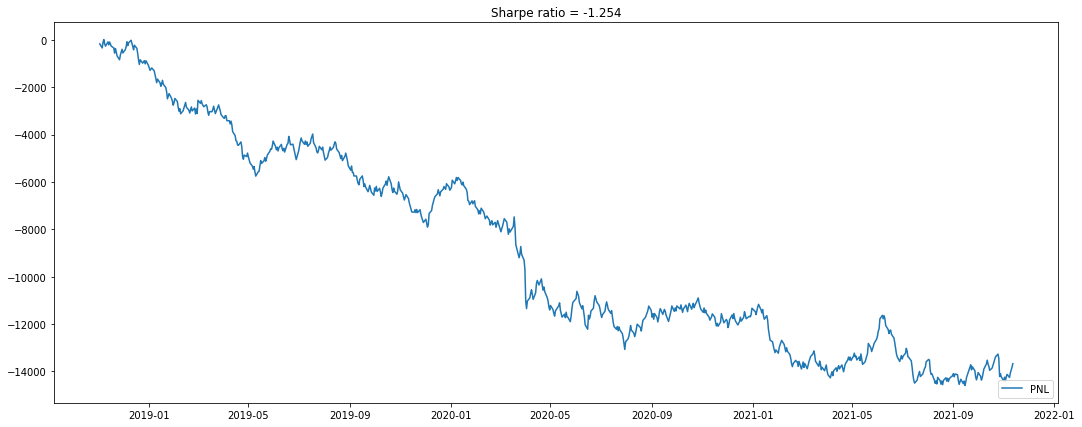

In [23]:
def start_strategy_observation(raw_data, PROFITS_LIST):
    TOTAL_PNL = [0]
    TRADE_DATES = list()
    SaveDicts = list()
    #   Итерируемся по всем уникальным дням в данных
    for correct_day in tqdm(np.unique(raw_data.index.date)[:]):
        Asian_end, Asian_start, Engilsh_end = selection_logic(correct_day)
        #   Проверяем, находятся ли нужные индексы в сырых данных
        if (Asian_end in raw_data.index) and (Asian_start in raw_data.index) and (Engilsh_end in raw_data.index):
            sampling_data = raw_data.loc[Asian_start:Engilsh_end].open
            result = buying_trigger(sampling_data=sampling_data, median_dot=Asian_end, SLIPADGE=10, POSITION_MONEY_VOLUME=PositionMoney, PROFITS_LIST=PROFITS_LIST)
            if result:
                TOTAL_PNL.append(TOTAL_PNL[-1] + result['operation_money_return'])
                #if TOTAL_PNL[-1] < 0:
                #    TOTAL_PNL[-1] = 0
                TRADE_DATES.append(result['position_close_time'].date())
                SaveDicts.append(result)
    TOTAL_PNL = TOTAL_PNL[1:]
    #SharpeReturn = SharpeModuleOld(TOTAL_PNL, TRADE_DATES, BEAUTIFUL_PNL=False)
    SharpeReturn = SharpeReturns(pd.DataFrame(SaveDicts))
    print(f"Sharpe = {SharpeReturn}")
    return TOTAL_PNL, TRADE_DATES, SaveDicts, SharpeReturn

PROFITS_LIST={
    "BUY":{
      "profit":.001,
      "loss":.001,
    },
    "SELL":{
      "profit":.001,
      "loss":.001,
    }
}

TOTAL_PNL, TRADE_DATES, SaveDicts, SharpeReturn = start_strategy_observation(raw_data=FX_data.iloc[: int(FX_data.shape[0] // 1)], PROFITS_LIST=PROFITS_LIST)
plt.figure(figsize=(18,7))
plt.title(f"Sharpe ratio = {SharpeReturn}")
plt.plot(TRADE_DATES, TOTAL_PNL, label='PNL')
plt.legend(loc='lower right')
plt.show()
df = pd.DataFrame(SaveDicts)
df
print(df.shape[0])

In [7]:
df.head(6)

,logic,operation_type,operation_position,position_open_time,open_price,holding_logic,position_close_time,position_close_price,operation_money_return,position_holding_time
0,True,BUY,105581.012311,2018-11-02 08:01:00,0.947140,STOP_LOSS,2018-11-02 09:29:00,0.946090,-120.860063,0 days 01:28:00
1,True,BUY,105960.264901,2018-11-05 11:17:00,0.943750,STOP_LOSS,2018-11-05 14:07:00,0.942700,-121.258278,0 days 02:50:00
2,True,BUY,105653.519847,2018-11-06 09:02:00,0.946490,TAKE_PROFIT,2018-11-06 11:08:00,0.947560,103.049266,0 days 02:06:00
3,True,BUY,104949.414382,2018-11-07 11:37:00,0.952840,TAKE_PROFIT,2018-11-07 12:05:00,0.953890,100.196885,0 days 00:28:00
4,True,BUY,104681.897883,2018-11-08 08:18:00,0.955275,STOP_LOSS,2018-11-08 11:56:00,0.954015,-141.899191,0 days 03:38:00
5,True,BUY,104614.000492,2018-11-09 11:25:00,0.955895,STOP_LOSS,2018-11-09 11:58:00,0.954815,-122.983121,0 days 00:33:00


In [8]:
FREE_RATE = 0.05/252
start_result = df
trade_days = list(df.position_close_time.dt.date.values)
#operation_returns = list(df.operation_money_return / PositionMoney)
trade_days = trade_days
if len(trade_days) > 2:
    MONEY_DF = pd.DataFrame(columns=['date', 'money_change'])
    for e, _ in enumerate(pd.date_range(min(trade_days), max(trade_days))):
        if _.date() in trade_days:
            money_change = np.nan
            found_string = start_result.iloc[trade_days.index(_)]
            if found_string.operation_type == 'BUY':
                money_change = (found_string.position_close_price/found_string.open_price) - 1 - FREE_RATE

            if found_string.operation_type == 'SELL':
                money_change = (found_string.open_price / found_string.position_close_price) - 1 - FREE_RATE
            money_change = found_string.operation_money_return / PositionMoney
            MONEY_DF = MONEY_DF.append([{'date': _.date(), 'money_change': money_change}])
        if _.date() not in trade_days:
            MONEY_DF = MONEY_DF.append([{'date': _.date(), 'money_change': 0}])

print(MONEY_DF.reset_index(drop=True))

            date  money_change
0     2018-11-02     -0.001209
1     2018-11-03      0.000000
2     2018-11-04      0.000000
3     2018-11-05     -0.001213
4     2018-11-06      0.001030
...          ...           ...
1102  2021-11-08     -0.001277
1103  2021-11-09     -0.001333
1104  2021-11-10      0.001008
1105  2021-11-11      0.001105
1106  2021-11-12      0.001076

[1107 rows x 2 columns]


In [9]:
print(np.sqrt(255) * MONEY_DF.money_change.mean() / MONEY_DF.money_change.std())

-1.5427879998947192


(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   0.,   0.,   4.,  98., 287.,   1.,   2.,   3., 341.,   1.,
          2.,   0., 277.,  69.,   7.,   4.,   1.,   5.]),
 array([-5.65568704e-03, -5.38385005e-03, -5.11201307e-03, -4.84017608e-03,
        -4.56833910e-03, -4.29650212e-03, -4.02466513e-03, -3.75282815e-03,
        -3.48099117e-03, -3.20915418e-03, -2.93731720e-03, -2.66548022e-03,
        -2.39364323e-03, -2.12180625e-03, -1.84996927e-03, -1.57813228e-03,
        -1.30629530e-03, -1.03445831e-03, -7.62621331e-04, -4.90784348e-04,
        -2.18947364e-04,  5.28896193e-05,  3.24726603e-04,  5.96563586e-04,
         8.68400570e-04,  1.14023755e-03,  1.41207454e-03,  1.68391152e-03,
         1.95574850e-03,  2.22758549e-03,  2.49942247e-03]),
 <BarContainer object of 30 artists>)

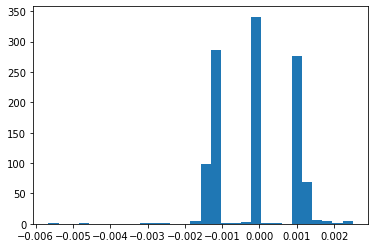

In [10]:
plt.hist(MONEY_DF.money_change, bins=30)

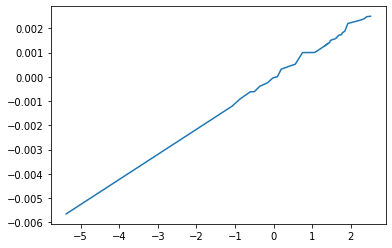

In [11]:
def q_q(df_data):
    mean = df_data.money_change.mean()
    std = df_data.money_change.std()
    dfn = (df_data.money_change - mean) / std
    dfn = dfn.values
    plt.plot([np.quantile(dfn, i / len(dfn)) for i,e in enumerate(dfn)], sorted(df_data.money_change))

q_q(MONEY_DF)

In [12]:
#SHARPE = MONEY_DF.money_change.replace(0, np.nan).mean() / MONEY_DF.money_change.replace(0, np.nan).std()


In [13]:
df[df.holding_logic == "STOP_LOSS"]


,logic,operation_type,operation_position,position_open_time,open_price,holding_logic,position_close_time,position_close_price,operation_money_return,position_holding_time
0,True,BUY,105581.012311,2018-11-02 08:01:00,0.947140,STOP_LOSS,2018-11-02 09:29:00,0.946090,-120.860063,0 days 01:28:00
1,True,BUY,105960.264901,2018-11-05 11:17:00,0.943750,STOP_LOSS,2018-11-05 14:07:00,0.942700,-121.258278,0 days 02:50:00
4,True,BUY,104681.897883,2018-11-08 08:18:00,0.955275,STOP_LOSS,2018-11-08 11:56:00,0.954015,-141.899191,0 days 03:38:00
5,True,BUY,104614.000492,2018-11-09 11:25:00,0.955895,STOP_LOSS,2018-11-09 11:58:00,0.954815,-122.983121,0 days 00:33:00
7,True,BUY,104843.233156,2018-11-13 08:06:00,0.953805,STOP_LOSS,2018-11-13 11:59:00,0.952720,-123.754908,0 days 03:53:00
...,...,...,...,...,...,...,...,...,...,...
755,True,BUY,107539.023223,2021-10-28 09:59:00,0.929895,STOP_LOSS,2021-10-28 12:13:00,0.928870,-120.227499,0 days 02:14:00
756,True,BUY,107207.564566,2021-10-29 08:06:00,0.932770,STOP_LOSS,2021-10-29 08:54:00,0.931705,-124.176056,0 days 00:48:00
757,True,SELL,107615.404069,2021-11-01 09:50:00,0.929235,STOP_LOSS,2021-11-01 15:23:00,0.930360,-131.067330,0 days 05:33:00
762,True,BUY,108449.283692,2021-11-08 09:00:00,0.922090,STOP_LOSS,2021-11-08 09:59:00,0.921005,-127.667473,0 days 00:59:00


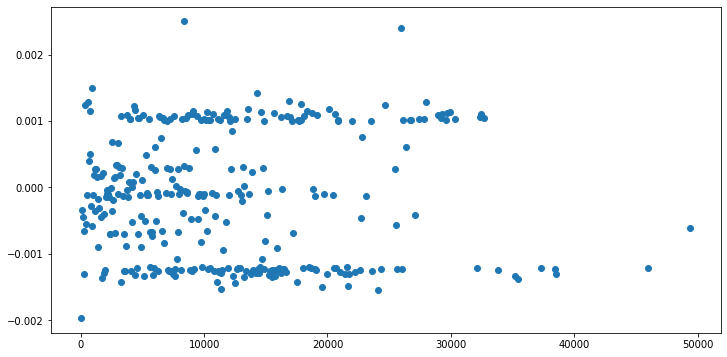

In [14]:
plt.figure(figsize=(12,6))
markdown = df.groupby(by='position_holding_time').mean().operation_money_return / PositionMoney
#markdown.index = pd.to_timedelta(markdown.index)



plt.plot(markdown.index.total_seconds(), markdown, 'o')

In [15]:
FX_data

,open,high,low,close
time,,,,
2018-11-01 00:15:00,0.931100,0.931135,0.930670,0.931025
2018-11-01 00:16:00,0.931025,0.931100,0.930965,0.931065
2018-11-01 00:17:00,0.931065,0.931120,0.930935,0.931090
2018-11-01 00:18:00,0.931090,0.931250,0.931090,0.931145
2018-11-01 00:19:00,0.931145,0.931175,0.931115,0.931115
...,...,...,...,...
2021-11-13 00:55:00,0.919965,0.920050,0.919885,0.919965
2021-11-13 00:56:00,0.919965,0.920120,0.919885,0.920035
2021-11-13 00:57:00,0.920035,0.920035,0.919930,0.919935


  0%|          | 0/2 [00:00<?, ?it/s]

INSAMPLE = IN:2018 - END:2019:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

Sharpe = -1.681
Sharpe = -1.015


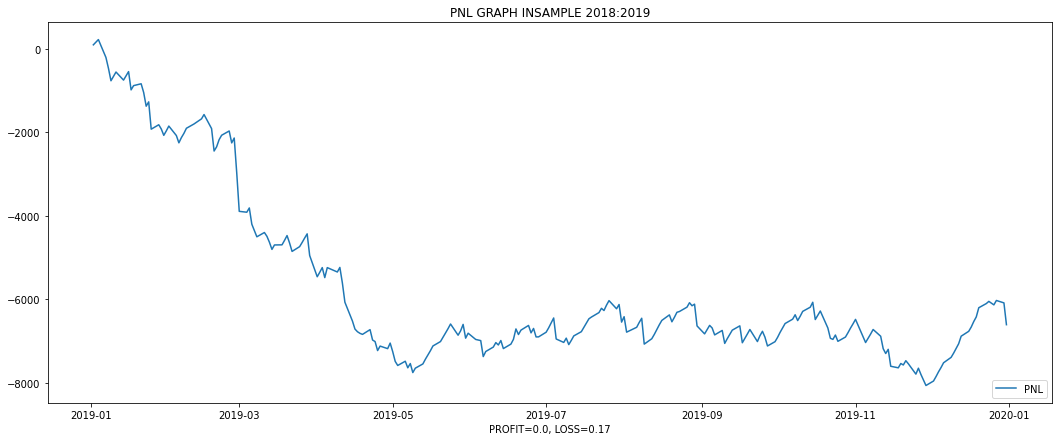

INSAMPLE = IN:2019 - END:2020:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

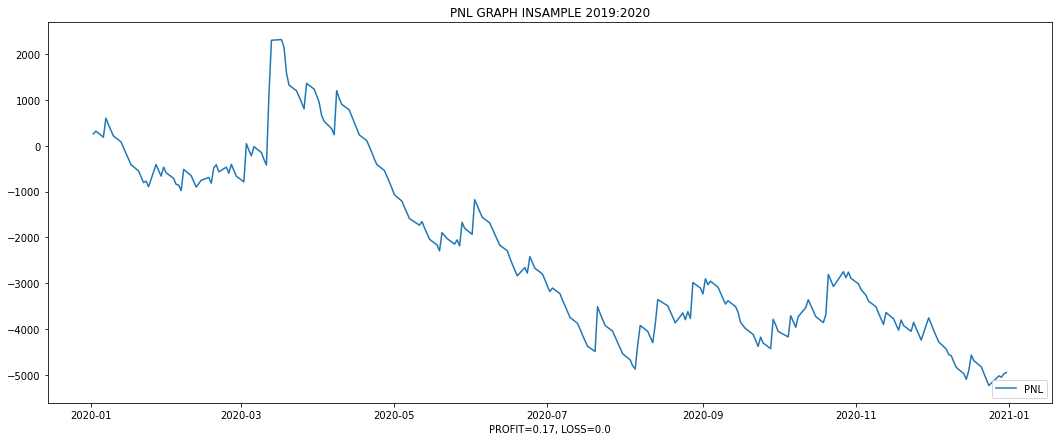

In [16]:
def create_params_dict(grid_element):
    PROFITS_LIST={
        "BUY":{
          "profit":grid_element[0],
          "loss":grid_element[1],
        },
        "SELL":{
          "profit":grid_element[0],
          "loss":grid_element[1],
        }
    }
    return PROFITS_LIST

all_data = FX_data

PROFITS_IT = np.linspace(.001, .5, 4)
LOSS_IT = np.linspace(.001, .5, 4)
GRID = np.unique(np.array(np.meshgrid(PROFITS_IT, LOSS_IT), dtype=np.float32).T.reshape(-1, 2), axis=0)[:10]

def tester(GRIDER_func, raw_data, GRIDER):
    TOTAL_PNL, TRADE_DATES, SaveDicts, SharpeReturn = start_strategy_observation(raw_data=raw_data, PROFITS_LIST=GRIDER_func)
    return {"PROFIT": GRIDER[0], "LOSS": GRIDER[1], "FINAL_PNL": TOTAL_PNL[-1]}

#   Нужно следить чтобы уникальных лет было не меньше 4
for year in tqdm(np.unique([x.year for x in FX_data.index.date])[:-2]):
    INSTART = year
    INEND = year + 1
    OUTSTART = year + 1
    OUTEND = year + 2
    INSAMPLE_DATA = all_data.loc[datetime.datetime(year=INSTART, month=1, day=1): datetime.datetime(year=INEND, month=1, day=1)]
    OUTSAMPLE_DATA = all_data.loc[datetime.datetime(year=OUTSTART, month=1, day=1): datetime.datetime(year=OUTEND, month=1, day=1)]
    RESULTS = Parallel(n_jobs=-1, verbose=0)(delayed(tester)(create_params_dict(GRIDER), INSAMPLE_DATA, GRIDER) for GRIDER in tqdm(GRID, leave=True, desc=f"INSAMPLE = IN:{INSTART} - END:{INEND}"))

    GRID_RESULT = pd.DataFrame(RESULTS).sort_values(by='FINAL_PNL', ascending=False).iloc[0]
    PROFIT_PERCENT = GRID_RESULT.PROFIT
    LOSS_PERCENT = GRID_RESULT.LOSS

    GRIDER = [PROFIT_PERCENT, LOSS_PERCENT]
    TOTAL_PNL, TRADE_DATES, SaveDicts, SharpeReturn = start_strategy_observation(raw_data=OUTSAMPLE_DATA, PROFITS_LIST=create_params_dict((GRIDER)))

    plt.figure(figsize=(18,7))
    plt.title(f"PNL GRAPH INSAMPLE {INSTART}:{INEND}")
    plt.xlabel(f"PROFIT={round(GRIDER[0],2)}, LOSS={round(GRIDER[1],2)}")
    plt.plot(TRADE_DATES, TOTAL_PNL, label='PNL')
    plt.legend(loc='lower right')
    plt.show()


In [17]:
GRID_RESULT = pd.DataFrame(RESULTS).sort_values(by='FINAL_PNL', ascending=False).iloc[0]
PROFIT_PERCENT = GRID_RESULT.PROFIT
LOSS_PERCENT = GRID_RESULT.LOSS

In [18]:
INSAMPLE_DATA

,open,high,low,close
time,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,NaN
2019-01-01 00:01:00,NaN,NaN,NaN,NaN
2019-01-01 00:02:00,NaN,NaN,NaN,NaN
2019-01-01 00:03:00,NaN,NaN,NaN,NaN
2019-01-01 00:04:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2019-12-31 23:56:00,0.910860,0.910940,0.910855,0.910920
2019-12-31 23:57:00,0.910920,0.911055,0.910920,0.911035
2019-12-31 23:58:00,0.911035,0.911035,0.911000,0.911025


In [19]:
np.unique([x.year for x in FX_data.index.date])

array([2018, 2019, 2020, 2021])

In [20]:
np.unique([x.year for x in FX_data.index.date])[:-2][1]

2019

In [21]:
#   MAKING GRID
PROFITS_IT = LOSS_IT = np.linspace(.001, .5, 4)
LOSS_IT = np.linspace(.001, .5, 4)
GRID = np.unique(np.array(np.meshgrid(PROFITS_IT, LOSS_IT), dtype=np.float32).T.reshape(-1, 2), axis=0)
grid_element = GRID[0]
def create_params_dict(grid_element):
    PROFITS_LIST={
        "BUY":{
          "profit":grid_element[0],
          "loss":grid_element[1],
        },
        "SELL":{
          "profit":grid_element[0],
          "loss":grid_element[1],
        }
    }
    return PROFITS_LIST

TOTAL_PNL, TRADE_DATES, SaveDicts, SharpeReturn = start_strategy_observation(raw_data=FX_data.iloc[: int(FX_data.shape[0] // 1)], PROFITS_LIST=PROFITS_LIST)

  0%|          | 0/1109 [00:00<?, ?it/s]

Sharpe = -1.534
